In [3]:
import pandas as pd

data = pd.read_csv('CH06.csv')
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 967 entries, 0 to 966
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    967 non-null    object
 1   Open    967 non-null    int64 
 2   High    967 non-null    int64 
 3   Low     967 non-null    int64 
 4   Volume  967 non-null    int64 
 5   Close   967 non-null    int64 
dtypes: int64(5), object(1)
memory usage: 45.5+ KB


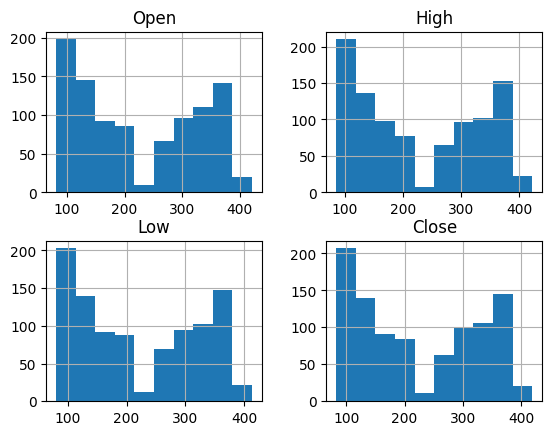

In [5]:
import matplotlib.pyplot as plt

data_used = data.iloc[:, 1:4]
data_used["Close"] = data["Close"]
hist = data_used.hist()
plt.show()

### 최소-최대 정규화(Min-Max Normalization)
최댓값은 1, 최소값은 0을 갖도록 데이터를 변환

In [6]:
# 넷플릭스 데이터셋 정의
import numpy as np
from torch.utils.data.dataset import Dataset


class Netflix(Dataset):
    def __init__(self):
        self.csv = pd.read_csv('CH06.csv')

        # 입력 데이터 정규화 
        self.data = self.csv.iloc[:, 1:4].values
        self.data = self.data / np.max(self.data)

        # 종가 데이터 정규화
        self.label = data["Close"].values
        self.label = self.label / np.max(self.label)

    def __len__(self):
        return len(self.data) - 30

    def __getitem__(self, i):
        data = self.data[i:i + 30]
        label = self.label[i + 30]

        return data, label


In [32]:
import torch
import torch.nn as nn


class RNN(nn.Module):
    def __init__(self) -> None:
        super(RNN, self).__init__()

        self.rnn = nn.RNN(input_size=3, hidden_size=8, num_layers=5, batch_first=True)

        self.fc1 = nn.Linear(in_features=240, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=1)

        self.relu = nn.ReLU()

    def forward(self, x, h0):
        x, hn = self.rnn(x, h0)
        
        x = torch.reshape(x, (x.shape[0],-1))
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        x = torch.flatten(x)

        return x
        

In [33]:
import tqdm

from torch.optim.adam import Adam
from torch.utils.data import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"

model = RNN().to(device)
dataset = Netflix()

#데이터 로더 정의
loader = DataLoader(dataset, batch_size=32)
optim = Adam(params=model.parameters(), lr=0.0001)

IndexError: too many indices for tensor of dimension 3

In [34]:
for epoch in range(200):
    iterator = tqdm.tqdm(loader)
    for data, label in iterator:
        optim.zero_grad()
        
        #은닉층의 모양 (RNN 은닉층 개수, 배치 개수, 출력의 차원)
        h0 = torch.zeros(5, data.shape[0], 8).to(device)
        
        pred = model(data.type(torch.FloatTensor).to(device), h0)
        
        loss = nn.MSELoss()(pred, label.type(torch.FloatTensor).to(device))
        
        loss.backward()
        optim.step()
        
        iterator.set_description(f"epoch{epoch} loss:{loss.item()}")
        
torch.save(model.state_dict(), './rnn.pth')

epoch49 loss:0.10252939164638519:  10%|█         | 3/30 [00:00<00:00, 67.64it/s]


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

loader = DataLoader(dataset, batch_size=1)

preds = []
total_loss = 0

with torch.no_grad():
    # 모델의 가중치 가져오기
    model.load_state_dict(torch.load('./rnn.pth'), map_location=device)
    
    for data, label in loader:
        h0 = torch.zeros(5, data.shape[0], 8).to(device)
        
        #모델의 예측 값 출력
        pred = model(data.type(torch.FloatTensor).to(device), h0)
        preds.append(pred.item())
        
        loss = nn.MSELoss()(pred, label.type(torch.FloatTensor).to(device))
        
        total_loss += loss/len(loader)
        